(quickstart)=

# Quickstart 

To get you started, here’s an annotated, fully-functional example that demonstrates a standard usage pattern for kdeLF. I will generate a synthetic dataset (or called simulated sample) from a known luminosity function (LF), and then apply kdeLF to it.


## Monte Carlo sampling from a known LF
The differential LF of a sample of objects is defined as the number of objects per unit comoving
volume per unit luminosity interval,

$$
\phi(\mathcal{L},z)=\frac{d^{2}N}{dVd\mathcal{L}},
$$

where $z$ denotes redshift and $\mathcal{L}$ denotes the luminosity.
Due to the typically large span of the luminosities, it is
often defined in terms of $\log \mathcal{L}$,

$$
\phi(L,z)=\frac{d^{2}N}{dVdL},
$$

where $L\equiv \log \mathcal{L}$ denotes the logarithm of luminosity. Our input LF has a pure density evolution form, with the density evolution function of

$$ 
e(z)=p_0\left[\left(\frac{1+z_c}{1+z}\right)^{p_1} + \left(\frac{1+z_c}{1+z}\right)^{p_2}\right]^{-1},
$$

where $p_0$ is the normalized parameter of $e(z)$ given by 

$$
p_0=\left[(1+z_c)^{p_1}+(1+z_c)^{p_2}\right],
$$

and

$$
\phi(L,z)=n_0e(z)\left(\frac{10^L}{L_*}\right)^{-\alpha}\exp\left[-\left(\frac{10^L}{L_*}\right)^{\beta}\right].
$$

In the above equations, $z_c$=2.0, $p_1$=1.5, $p_2$=$-5$, $L_*$=$10^{25}$, $n_0$=$10^{-5}$, $\alpha$=0.45, $\beta$=0.3, are free parameters. The users may change the parameter values, or even provide a quite different form of input LF for the Monte Carlo sampling.  

The first thing that we need to do is import the necessary modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import dblquad
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from tqdm import tqdm

Then, we’ll code up a Python function that returns the density evolution function $e(z)$ and the input (true) LF $\phi(L,z)$, called `phi_true`:

In [2]:
zc,p1,p2,L0,n0,alpha,beta=2.0,2.0,-4.5,25.0,-5.0,0.45,0.30

def e(z):
    rho=1.0/( ((1+zc)/(1+z))**p1 + ((1+zc)/(1+z))**p2 ) * ( ((1+zc)/(1+0.0))**p1 + ((1+zc)/(1+0.0))**p2)
    return rho
    
def phi_true(z,L):
    L_z=10**L0
    rho=10**n0 * (10**L/L_z)**(-alpha)*np.exp(-(10**L/L_z)**beta) * e(z)
    return rho

Then, we’ll code up a Python function that returns the truncation boundary $f_{\mathrm{lim}}(z)$ of the sample, called `f_lim`. Here we consider the case for the common flux-limited samples, $f_{\mathrm{lim}}(z)$ is given by

$$
f_{\mathrm{lim}}(z)=4\pi d_L^{2}(z)(1/K(z))F_{\mathrm{lim}},
$$

where $d_L(z)$ is the luminosity distance, $F_{\mathrm{lim}}$ is the survey flux limit, and $K(z)$ represents the $K$-correction. 

In [3]:
flux,alpha= 0.001,0.75
H0,Om0 = 70, 0.3 
Mpc=3.08567758E+022 
c=299792.458
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
## your own f_lim function : 
def f_lim(z):
    St=flux
    dist=cosmo.luminosity_distance(z)
    ans=dist.value
    return np.log10(4*np.pi*(ans*Mpc)**2*St*1E-26/(1.0+z)**(1.0-alpha))

Set the redshift and luminosity ranges, as well as the desired sample size for the simulated sample: 

In [4]:
z1,z2,L1,L2=0.0,6.0,22.0,30.0
ndata=8000
#The actual sample size of the simulated sample will not exactly equals to ndata, but should be very close.  

The following code will estimate the solid angle `omega` (unit of $sr$) of the simulated sample: 

In [5]:
def rho(L,z):
    dvdz=cosmo.differential_comoving_volume(z).value
    result=phi_true(z,L)*dvdz  
    return result

ans=dblquad(rho, z1, z2, lambda z: L1, lambda z: L2)
ans_lim=dblquad(rho, z1, z2, lambda z: f_lim(z), lambda z: L2)
omega=ndata/ans_lim[0]
N_tot=math.ceil(ans[0]*omega)
print("The solid angle 'omega' of the simulated sample:",'%.4f' % omega)

The solid angle 'omega' of the simulated sample: 0.0120


We then code up the marginal probability density distributions (PDFs) for $z$ and $L$, and prepare for a Monte Carlo sampling:

In [6]:
def pz(z):             # the PDF of z, not normalized
    dvdz=cosmo.differential_comoving_volume(z).value    
    return e(z)*dvdz

def pl(L):         # the PDF of L, not normalized 
    L_z=10**L0
    result= (10**L/L_z)**(-alpha)*np.exp(-(10**L/L_z)**beta) 
    return result

ans=quad(pz,z1,z2)
nomz=ans[0]
ans=quad(pl,L1,L2)
noml=ans[0]
#print('nomz,noml',nomz,noml)

res = minimize_scalar(lambda z: -pz(z)/nomz, bounds=(z1, z2), method='bounded')
zmp=res.x
max_pz=-res.fun
#print('zmax',zmp,max_pz)
res = minimize_scalar(lambda L: -pl(L)/noml, bounds=(L1, L2), method='bounded')
lmp=res.x
max_pl=max(-res.fun,pl(L1)/noml)
#print('Lmax',lmp,max_pl)
Lambta_z=1.0/max_pz
Lambta_L=1.0/max_pl

Start sampling with the rejection method：

In [7]:
from random import seed, random
from multiprocessing import Pool, cpu_count
        
cores = cpu_count()-1
N_simu=math.ceil(N_tot/cores)

def sampler(ir):
    rst=[]
    if ir==0:
        irs=tqdm(range(N_simu))
    else:
        irs=range(N_simu)
    for i in irs:        
        seed()
        while True:            
            si1=random()
            Delta_z=z1+(z2-z1)*si1
            si2=random()           
            Judge_z=Lambta_z*pz(Delta_z)/nomz
            if si2<=Judge_z:
                z_simu=Delta_z
                break

        while True:            
            Xi_L1=random()
            Delta_L=L1+(L2-L1)*Xi_L1
            Xi_L2=random()   
            Judge_L=Lambta_L*pl(Delta_L)/noml
            if Xi_L2<=Judge_L:
                L_simu=Delta_L
                break            
    
        Llim=f_lim(z_simu)
        if L_simu>Llim:
            rst.append((z_simu,L_simu))          
    return rst

ps=np.arange(cores)        

if __name__ == '__main__':
    pool = Pool(cores) # Create a multiprocessing Pool
    rslt = pool.map(sampler, ps)  # process data_inputs iterable with pool
    pool.close()
    pool.join()
    
f = open('data.txt', "w")
for i in range(len(rslt)):    
    for j in range(len(rslt[i])):
        print('%.6f' %rslt[i][j][0],'%.6f' %rslt[i][j][1],file=f)
f.close()


100%|█████████████████████████████████| 272350/272350 [03:54<00:00, 1161.95it/s]


The synthetic data has been saved to to `data.txt`. The following code will plot the synthetic data:

total number: 7873


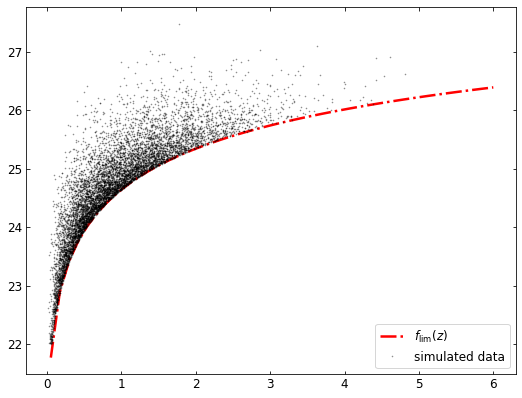

In [8]:
with open('data.txt', 'r') as f: 
    red,lum= np.loadtxt(f, usecols=(0,1), unpack=True)
print('total number:',red.size)    
zs=np.linspace(0.05,6)
ls=f_lim(zs)
plt.figure(figsize=(8,6)) 
ax=plt.axes([0.1,0.1, 0.85, 0.85])
ax.tick_params(direction='in', top=True, right=True, labelsize=12)
plt.plot(zs,ls,'-.',color=(1.0,0.0,0.0),linewidth=2.5, label=r'$f_{\mathrm{lim}}(z)$')      
plt.plot(red,lum,'.',ms=1.2,color=(0.0,0.0,0.0),label='simulated data',alpha=0.4)
ax.legend(fontsize=12,loc='lower right')
plt.show()

## Apply kdeLF to the simulated sample

Set the range of redshift. Generally we let Z1 be slightly less than the minimum redshift of sample, and Z2 be slightly greater than the maximum redshift:

In [9]:
print(min(red),max(red))

0.014599 4.810231


In [10]:
Z1, Z2 =0.01,4.90

The main interface provided by kdeLF is the `KdeLF` object. It acts as the interface that receives the input of required and optional arguments to initialize a calculation. The following code will initialize a KdeLF instance, named "lf1":

In [11]:
from kdeLF import kdeLF 

lf1 = kdeLF.KdeLF(sample_file='data.txt', solid_angle=omega, zbin=[Z1,Z2], f_lim=f_lim, 
                  H0=H0, Om0=Om0, small_sample=False, adaptive=False)

The first four arguments are required and the others are optional. `sample_file` is the name of sample file that contains at least two columns of data for $z$ and $L$ (or absolute magnitude $M$). `zbin` is the redshift range $[Z_1,Z_2]$. `f_lim` is the user defined Python function calculating the truncation boundary $f_{\mathrm{lim}}(z)$ of sample, and `solid_angle` is the solid angle (unit of $sr$) subtended by the sample. kdeLF adopts a Lambda Cold Dark Matter (LCDM) cosmology, but it is not limited to this specific cosmological model. The optional arguments `Om0` and `H0`, defaulting as $0.30$ and 70 (km s$^{-1}$ Mpc$^{-1}$), represent the $\Omega_{m}$ parameter and Hubble constant for the LCDM cosmology, respectively.

In our paper [(Yuan et al. 2022)](https://arxiv.org/abs/2203.06700), our KDE method provided **four LF estimators. We denote the LF estimated by Equation (15) in our paper as <font color='OrangeRed'> $\hat{\phi}$ </font>, and the small sample approximation by Equation (25) as <font color='OrangeRed'> $\hat{\phi}_{\mathrm{1}}$ </font>. Their adaptive versions are denoted as <font color='OrangeRed'> $\hat{\phi}_{\mathrm{a}}$ </font> and <font color='OrangeRed'> $\hat{\phi}_{\mathrm{1a}}$ </font>, respectively**. The other two optional arguments of `KdeLF`, `small_sample` and `adaptive`, have four different combinations, <font color='Green'> (False, False) </font>, <font color='Green'> (False, True) </font>, <font color='Green'> (True, False) </font> and <font color='Green'> (True, True) </font>, corresponding to the usages of $\hat{\phi}$, $\hat{\phi}_{\mathrm{a}}$, $\hat{\phi}_{\mathrm{1}}$ and $\hat{\phi}_{\mathrm{1a}}$, respectively.

After the above initialization, kdeLF is ready for calculating the LF using the <font color='OrangeRed'> $\hat{\phi}$ </font> estimator. We can obtain the optimal bandwidths of KDE by the `KdeLF.get_optimal_h ()` function:

In [12]:
lf1.get_optimal_h()

z & L data loaded
Maximum likelihood estimation by scipy.optimize 'Powell' method,
redshift bin: ( 0.01 , 4.9 )
sample size of this bin: 7872
bandwidths for 2d estimator,
    Initial h1 & h2:      [0.15, 0.15]
    bounds for h1 & h2:   [(0.001, 1.0), (0.001, 1.0)]
    Optimal h1 & h2:
         0.3019 0.1059
Cost total time: 7.72  second


array([0.3019075 , 0.10594656])

Once having the optimal bandwidths, we can get the LF estimates at any point $(z, L)$ in the in the domain of $\{Z_1<z<Z_2,~ L>f_{\mathrm{lim}}(z) \}$, e.g.,

In [13]:
lf1.phi_kde(0.5,25.0,[0.32395053, 0.10842562])

7.809333168741918e-06

More often, we are interested in plotting the LF at some given redshift, which can be achieved by the `KdeLF.get_lgLF()` function. This will return a two-dimensional array giving the mesh points for $L$ and the LF estimates.

In [14]:
lfk=lf1.get_lgLF(z=0.5,plot_fig=False)

For comparison, we also try the adaptive KDE method: <font color='OrangeRed'> $\hat{\phi}_{\mathrm{a}}$ </font>: 

In [15]:
lf2 = kdeLF.KdeLF(sample_file='data.txt', solid_angle=omega, zbin=[Z1,Z2], f_lim=f_lim, 
                  H0=H0, Om0=Om0, small_sample=False, adaptive=True)

lf2.get_optimal_h() 

z & L data loaded
Maximum likelihood estimation by scipy.optimize 'Powell' method,
redshift bin: ( 0.01 , 4.9 )
sample size of this bin: 7872
bandwidths for 2d estimator,
    Initial h1 & h2:      [0.15, 0.15]
    bounds for h1 & h2:   [(0.001, 1.0), (0.001, 1.0)]
    Optimal h1 & h2:
         0.3019 0.1059
pilot bandwidths:
    h1p & h2p: 0.3019 0.1059 

global bandwidths and beta for adaptive 2d estimator,
    Initial h10, h20 & beta:      [0.15 0.15 0.3 ]
    bounds for h10, h20 & beta:   [(0.001, 1.0), (0.001, 1.0), (0.01, 1.0)]
    Optimal h10, h20 & beta:
         0.1151 0.0606 0.2505 

Cost total time: 21.92  second


array([0.1151027 , 0.06057506, 0.25046887])

In [16]:
lfka=lf2.get_lgLF(z=0.5,plot_fig=False)

It would be valuable to compare our KDE method with the classical binning estimator. kdeLF provides the `KdeLF.get_binLF ()` function to get the LF estimates using [Page & Carrera (2000)](https://arxiv.org/abs/2203.06700) 's binning estimator, denoted as <font color='OrangeRed'> $\hat{\phi}_{\mathrm{bin}}$ </font>.

In [17]:
blf=lf1.get_binLF(Lbin=0.3,zbin=[0.3,0.7],plot_fig=False)

This will return a tuple containing the arrays of $L$ and the LF estimates, as well as their errors. Then we plot the LFs obtained by different estimators:

In [18]:
def plot_lfs(z_plot,lfk=None,lfka=None,blf=None,lfk1a=None):
    lum=np.linspace(22.0,29.0)
    plt.figure(figsize=(8,6)) 
    ax=plt.axes([0.13,0.1, 0.82, 0.85])
    ax.tick_params(direction='in', top=True, right=True, labelsize=12)
    phi=np.log10(phi_true(z_plot,lum))   
    plt.plot(lum,phi,linestyle='-.',color='green',linewidth=0.8, label=r'$\phi_{\mathrm{true}}$')
    if lfk is not None:
        plt.plot(lfk[0],lfk[1],color=(0.0,0.0,1.0),linewidth=1.5, label=r'$\hat{\phi}$')
    if lfka is not None:
        plt.plot(lfka[0],lfka[1],color='red',linewidth=2.5, alpha=0.8, label=r'$\hat{\phi}_{\mathrm{a}}$')
    if lfk1a is not None:
        plt.plot(lfk1a[0],lfk1a[1],color='cyan',linewidth=2.5, alpha=0.8, label=r'$\hat{\phi}_{\mathrm{1a}}$')        
    if blf is not None:
        plt.plot(blf[0],blf[3],'o',mfc='white',mec='black',ms=9,mew=0.7,alpha=0.7,label=r'$\hat{\phi}_{\mathrm{bin}}$')  
    ax.errorbar(blf[0],blf[3], ecolor='k', capsize=0,                
                xerr=np.vstack((blf[1], blf[2])),
                yerr=np.vstack((blf[4], blf[5])),
                fmt='None', zorder=4,alpha=0.5)
    plt.ylabel(r'$\log_{10}( \phi(z,L) ~/~ {\rm Mpc}^{-3} ~ \Delta L^{-1} )$',fontsize=18)
    ax.legend(fontsize=12,loc='upper right')
    plt.xlabel(r'$L$',fontsize=18) 
    plottitle = r'$z={0:.2f}$'.format(z_plot)
    plt.title(plottitle, size=14, y=1.01)
    if blf is not None:
        x1,x2=max((min(blf[0])-2), min(lum)), min((max(blf[0])+2), max(lum))
        y1,y2=min(blf[3])-2,max(blf[3])+1
        plt.xlim(x1,x2)
        plt.ylim(y1,y2)
    plt.show()  

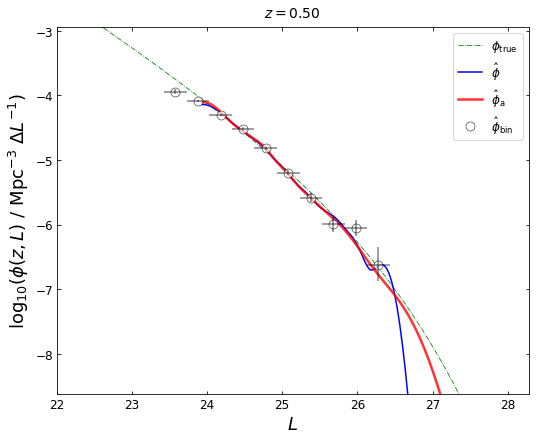

In [19]:
plot_lfs(z_plot=0.5,lfk=lfk,lfka=lfka,blf=blf) 

We can plot the LFs at any redshift in the interval of $(Z_1, Z_2)$：

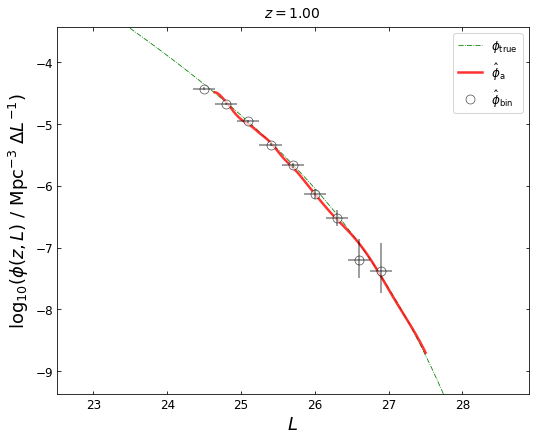

In [20]:
z_plot=1.0
blf=lf1.get_binLF(Lbin=0.3,zbin=[0.75,1.25],plot_fig=False)
lfka=lf2.get_lgLF(z=z_plot,plot_fig=False)  
plot_lfs(z_plot=z_plot,lfka=lfka,blf=blf) 

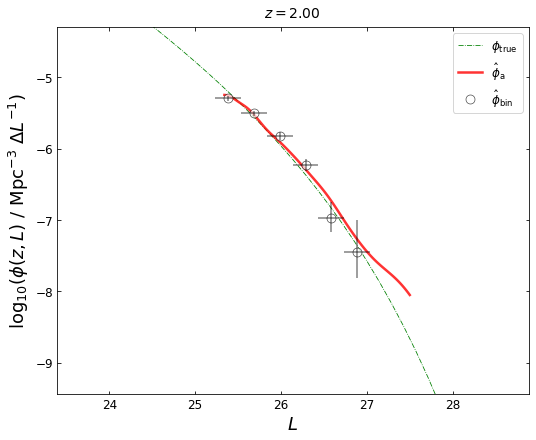

In [21]:
z_plot=2.0
blf=lf1.get_binLF(Lbin=0.3,zbin=[1.8,2.2],plot_fig=False)
lfka=lf2.get_lgLF(z=z_plot,plot_fig=False)  
plot_lfs(z_plot=z_plot,lfka=lfka,blf=blf) 

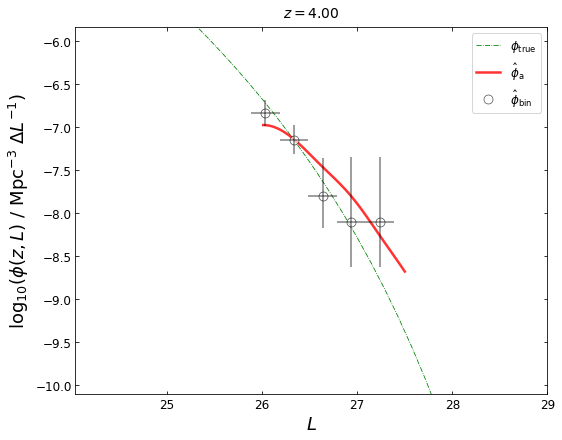

In [22]:
z_plot=4.0
blf=lf2.get_binLF(Lbin=0.3,zbin=[3.5,4.5],plot_fig=False)
lfka=lf2.get_lgLF(z=z_plot,plot_fig=False)
plot_lfs(z_plot=z_plot,lfk=None,lfka=lfka,blf=blf) 

We note that the LF at z=4 given by $\hat{\phi}_{\mathrm{a}}$ is not good, mainly because the sources near z~4 is very sparse.  

In [23]:
select=((red>3.5) & (red<4.5))
print('number:',len(red[select]))

number: 24


There are only 24 sources in the (3.5,4.5) redshift bin. For this small sample case, a better solution is using the small sample approximation KDE method:

In [24]:
lf3=kdeLF.KdeLF(sample_file='data.txt', solid_angle=omega, zbin=[3.5,4.5], f_lim=f_lim, 
                H0=H0, Om0=Om0, adaptive=True, small_sample=True)
lf3.get_optimal_h()

z & L data loaded
Maximum likelihood estimation by scipy.optimize 'Powell' method,
redshift bin: ( 3.5 , 4.5 )
sample size of this bin: 24
bandwidth for 1d estimator,
    bound for h:   (0.001, 1.0)
    Optimal h:     0.2928
pilot bandwidth:
    hp: 0.2928 

global bandwidth and beta for adaptive 1d estimator,
    Initial h0 & beta:      [0.29283326 0.3       ]
    bounds for h0 & beta:   [(0.001, 1.0), (0.01, 1.0)]
    Optimal h0 & beta:
         0.3916 1.0000


array([0.3916132, 1.       ])

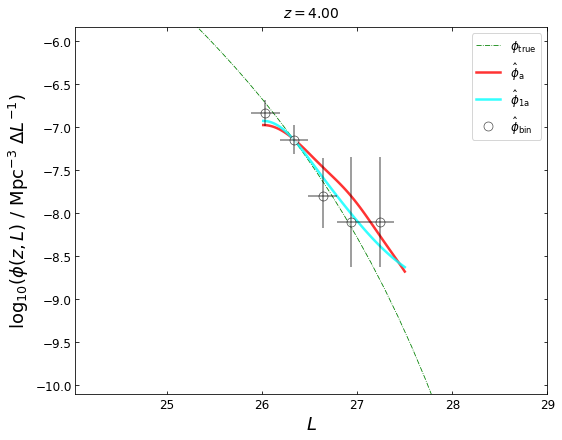

In [25]:
z_plot=4.0
lfk1a=lf3.get_lgLF(z=z_plot,plot_fig=False)
blf=lf3.get_binLF(Lbin=0.3,zbin=[3.5,4.5],plot_fig=False)
plot_lfs(z_plot=z_plot,lfk1a=lfk1a,lfka=lfka,blf=blf) 

## MCMC & uncertainty estimation

The `KdeLF.get_optimal_h()` function can only give the "best-fit" values for the bandwidths. If you want an uncertainty estimation to the bandwidths, you can use the `KdeLF.run_mcmc()` function. It implements a fully Bayesian Markov Chain Monte Carlo (MCMC) method to determine the posterior distributions of bandwidths and other parameters (e.g., $\beta$ for adaptive KDE). The MCMC core embedded in kdeLF is the Python package [emcee](https://emcee.readthedocs.io/en/v3.1.1/). `KdeLF.run_mcmc()` uses the ensemble MCMC sampler provided by emcee to draw parameter samples from the posterior probability distribution (the adaptive KDE $\hat{\phi}_{\mathrm{a}}$ for example): 

$$
    p (h_{10},h_{20},\beta\,|\,z_{\mathrm{i}},L_{\mathrm{i}}) \propto p(h_{10},h_{20},\beta)\,p(z_{\mathrm{i}},L_{\mathrm{i}}\,|\,h_{10},h_{20},\beta) \quad ,
$$

where $p(z_{\mathrm{i}},L_{\mathrm{i}}\,|\,h_{10},h_{20},\beta)$ is the likelihood function (see Section 2.3 of [(Yuan et al. 2022)](https://arxiv.org/abs/2203.06700) for details). Its calculation is completed automatically by the program. $p(h_{10},h_{20},\beta)$ is the prior distribution, and by default, we use uniform (so-called “uninformative”) priors on $h_{10}$, $h_{20}$, and $\beta$. 

In [26]:
lfmc = kdeLF.KdeLF(sample_file='data.txt', solid_angle=omega, zbin=[Z1,Z2], f_lim=f_lim, 
                  H0=H0, Om0=Om0, small_sample=False, adaptive=True)
lfmc.get_optimal_h(quiet=True)

z & L data loaded


array([0.1151027 , 0.06057506, 0.25046887])

 72%|█████████████████████████          | 2150/3000 [6:02:31<2:23:19, 10.12s/it]


burn-in: 84
thin: 16
flat chain shape: (4128, 3)
flat log prob shape: (4128,)


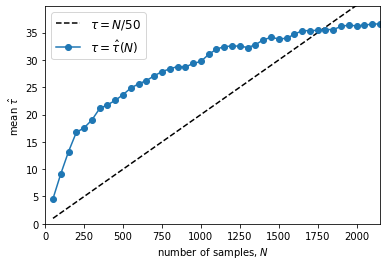

In [27]:
lfmc.run_mcmc() 
# full parameter usage: lfmc.run_mcmc(max_n=3000, Ntau=50, initial_point=None, 
#                                     parallel=False, priors=None, chain_analysis=False)

Running the above code is generally time-consuming. It may take several minutes to tens hours, depending on the sample size and your CPU performance. The program incrementally save the state of the chain to a [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) file (suppose you have the [h5py library](http://www.h5py.org) installed). The code will run the chain for up to `max_n` (default=3000) steps and check the autocorrelation time every 50 steps. If the chain is longer than `Ntau` (default=50) times the estimated autocorrelation time and if this estimate changed by less than 1%, we’ll consider it converged. Larger values of `Ntau` will be more conservative, but they will also require longer chains (see the [emcee document](https://emcee.readthedocs.io/en/v3.1.1/tutorials/autocorr/) for details).

A successful running will produce a figure showing the autocorrelation time estimate as a function of chain length. If the chain converges, the blue curve should cross the black dashed line. You will also find a '.h5' file like 'chain_a0.01_4.9.h5' (automatically named by the program) in the current folder. Then we use the `KdeLF.chain_analysis()` function to visualize the chain:

burn-in: 84
thin: 16
flat chain shape: (4128, 3)
flat log prob shape: (4128,)
 
********** MCMC bestfit and 1 sigma errors **********
 h10 = 0.1307 - 0.0205 + 0.0233
 h20 = 0.0666 - 0.0102 + 0.0109
beta = 0.2302 - 0.0323 + 0.0331
 


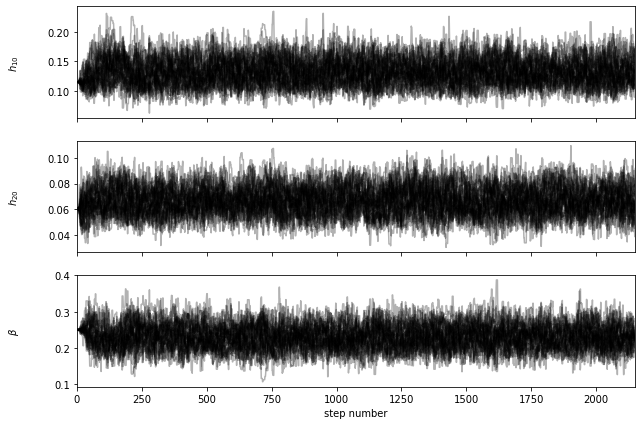

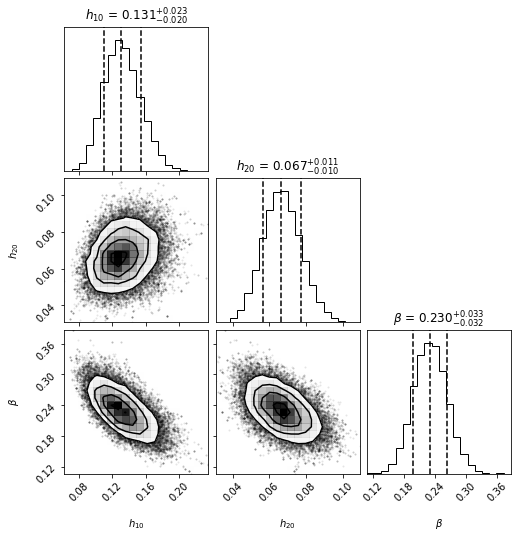

In [28]:
lfmc.chain_analysis('chain_a0.01_4.9.h5')

Now we can get the posterior distributions for LFs using the `KdeLF.plot_posterior()` function. This will return a tuple containing the arrays of $L$, the posterior median LFs, and the errors.

In [29]:
lf0_5 = lfmc.plot_posterior_LF(z=0.5,sigma=3,plot_fig=False)
lums, phi_mcmc, lower_error, upper_error = lf0_5

100%|███████████████████████████████████████| 1500/1500 [00:22<00:00, 66.90it/s]


Now let's plot the result. The red curve shows our MCMC best-fit LF, which is represented by the median of the posterior probability distribution function. The orange shaded area shows the 3$\sigma$ uncertainty (99.93\% equal-tailed credible interval).

In [30]:
def plot_lfs_mcmc(z_plot, blf, lf_mcmc):
    lums, phi_mcmc, lower_error, upper_error = lf_mcmc
    lum=np.linspace(22.0,29.0)
    phi=np.log10(phi_true(z_plot,lum)) 
    plt.figure(figsize=(9,7)) 
    ax=plt.axes([0.13,0.1, 0.82, 0.85])
    ax.tick_params(direction='in', top=True, right=True, labelsize=12)
    plt.plot(lum,phi,linestyle='--',color='green',linewidth=0.8, label=r'$\phi_{\mathrm{true}}$')

    ###############  plot the posterior distributions for LFs ##############
    ax.fill_between(lums, lower_error, y2=upper_error, color='orange', alpha=0.4)
    ax.plot(lums, phi_mcmc, lw=2.0, c='red', label=r'$\hat{\phi}_{\mathrm{a,MCMC}}$')

     ###############  plot the binning LFs with errorbars ###################
    plt.plot(blf[0],blf[3],'o',mfc='white',mec='black',ms=9,mew=0.7,alpha=0.7,label=r'$\hat{\phi}_{\mathrm{bin}}$')  
    ax.errorbar(blf[0],blf[3], ecolor='k', capsize=0, xerr=np.vstack((blf[1], blf[2])),
                yerr=np.vstack((blf[4], blf[5])), fmt='None', zorder=4,alpha=0.5)

    plt.ylabel(r'$\log_{10}( \phi(z,L) ~/~ {\rm Mpc}^{-3} ~ \Delta L^{-1} )$',fontsize=18)
    ax.legend(fontsize=12,loc='upper right')
    plt.xlabel(r'$L$',fontsize=18) 
    plottitle = r'$z={0:.2f}$'.format(z_plot)
    plt.title(plottitle, size=14, y=1.01)    
    x1,x2=max((min(blf[0])-2), min(lum)), min((max(blf[0])+2), max(lum))
    y1,y2=min(blf[3])-2,max(blf[3])+1
    plt.xlim(x1,x2)
    plt.ylim(y1,y2)
    plt.show() 

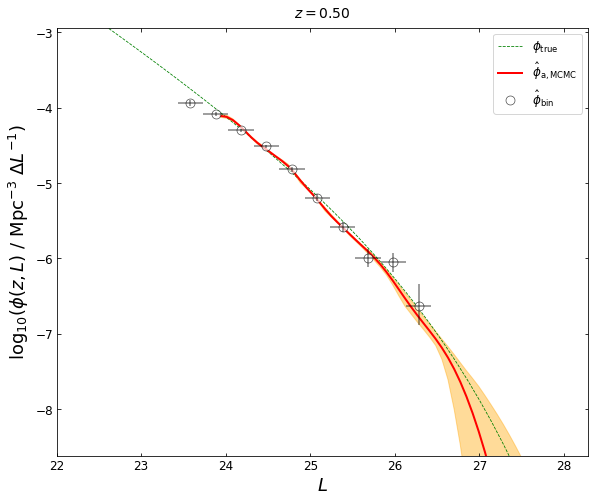

In [31]:
blf=lfmc.get_binLF(Lbin=0.3,zbin=[0.3,0.7],plot_fig=False)    # get the binning LFs
plot_lfs_mcmc(z_plot=0.5, blf=blf, lf_mcmc=(lums, phi_mcmc, lower_error, upper_error))

The following lines of code implement the small sample approximation KDE method:

In [32]:
lf1a = kdeLF.KdeLF(sample_file='data.txt', solid_angle=omega, zbin=[3.5,4.5], f_lim=f_lim, 
                  H0=H0, Om0=Om0, small_sample=True, adaptive=True)
lf1a.get_optimal_h(quiet=True)    

z & L data loaded


array([0.3916132, 1.       ])

 58%|██████████████████████▊                | 1750/3000 [00:33<00:23, 52.30it/s]


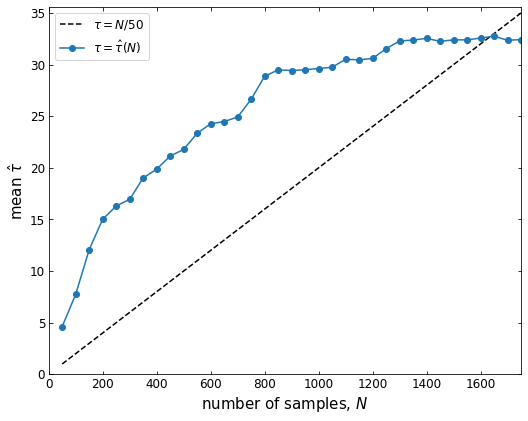

In [33]:
lf1a.run_mcmc(parallel=True, priors=[(0.01, 1.0),(0, 1)],initial_point=[0.39,0.5])

burn-in: 67
thin: 15
flat chain shape: (3584, 2)
flat log prob shape: (3584,)
 
********** MCMC bestfit and 1 sigma errors **********
 h0 = 0.3553 - 0.1099 + 0.1384
beta = 0.6765 - 0.3360 + 0.2317
 


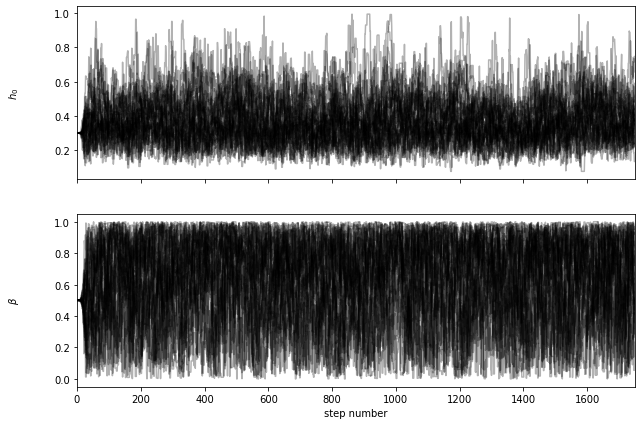

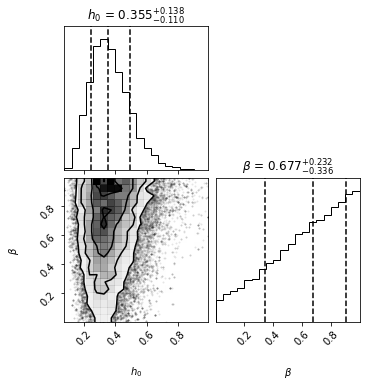

In [34]:
lf1a.chain_analysis('chain_a3.5_4.5.h5')         

In [35]:
lf4_0 = lf1a.plot_posterior_LF(z=4.0,sigma=3,plot_fig=False,dpi=(50,3000))
lums, phi_mcmc, lower_error, upper_error = lf4_0

100%|██████████████████████████████████████| 3000/3000 [00:14<00:00, 208.11it/s]


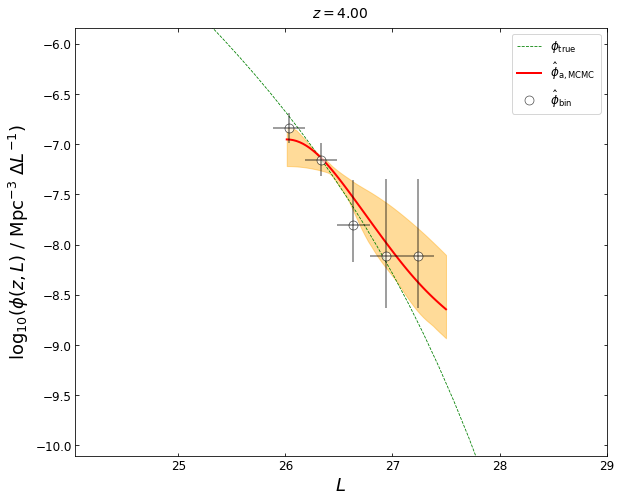

In [36]:
blf=lf1a.get_binLF(Lbin=0.3,zbin=[3.5,4.5],plot_fig=False)    # get the binning LFs
plot_lfs_mcmc(z_plot=4.0, blf=blf, lf_mcmc=(lums, phi_mcmc, lower_error, upper_error))